In [3]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
import os,sys
from PIL import Image

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import backend as K
from keras.regularizers import l2
from keras.layers import LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


/Users/Skolebruker/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Loaded a set of images
drivedir = "drive/My Drive/"
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)

In [77]:

n = min(100, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


n = 100 # Only use 10 images for training

Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


Image size = 400,400


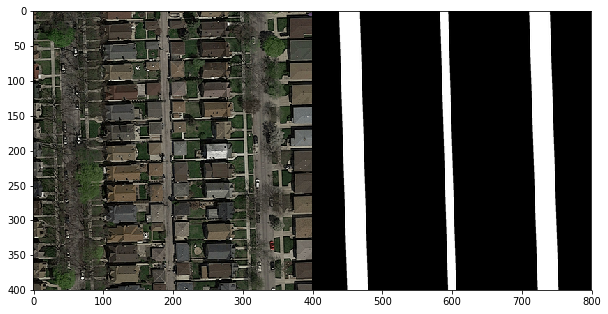

In [78]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [58]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]
# Linearize list of patches
#shape is 10*625 (10 images, cut up into 625 images with 16*16)
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])    
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [44]:
img_patches.shape

(62500, 16, 16, 3)

In [9]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def split_data(x, y, ratio, seed=1):
    #select a cutting point based on ratio
    cut = int(round(len(x)*ratio))
    x_test = x[cut:]
    x_train = x[:cut]
    y_test = y[cut:]
    y_train = y[:cut]
    
    ### END CODE HERE ###
    return x_train, x_test, y_train, y_test

Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])





In [11]:
original_picture_count = len(img_patches)
new_imgs = img_patches.copy()
new_Y = Y.copy()
for i in range(1,4):
    flip_img = img_patches.copy()
    for j in range (original_picture_count):
        flip_img[j] = np.rot90(img_patches[j], i)
    new_imgs = np.concatenate((new_imgs, flip_img), axis=0)
    new_Y = np.concatenate((new_Y, Y.copy()), axis=0)


In [12]:
x_train, x_test, y_train, y_test = split_data(new_imgs,new_Y,0.1)

X = np.asarray([ extract_features_2d(x_test[i]) for i in range(len(x_test))])

In [13]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(len(set(Y))))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 225000 features
Feature dimension = 2
Number of classes = 2
Class 0: 46309 samples
Class 1: 16191 samples


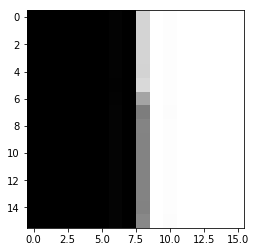

In [14]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

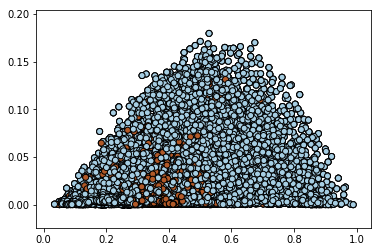

In [15]:
# Plot 2d features using groundtruth to color the datapoints
# Rødt er vei
plt.scatter(X[:, 0], X[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired)

In [16]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, y_test)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [23]:
#make sequential model
model = Sequential()

window_size = 16
classes = 2
pool_size = (2, 2)
#Sier noe om størrelse på det som går inn
input_shape = (window_size, window_size, 3)
# 64 5x5 filters
model.add(Conv2D(64, (5,5), border_mode="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(128, (3, 3), border_mode="same"))
model.add(Conv2D(256, (3, 3), border_mode="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))


model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
             optimizer ="adam",
             metrics =["accuracy"])




/Users/Skolebruker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(16, 16, 3..., padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/Users/Skolebruker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  
/Users/Skolebruker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
  from ipykernel import kernelapp as app


In [ ]:
    model = Sequential()
    reg = 1e-6 # L2 regularization factor (used on weights, but not biases)

    model.add(Convolution2D(64, 5, 5, # 64 5x5 filters
                                border_mode='same',
                                input_shape=input_shape
                               ))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=pool_size, border_mode='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, 3, 3, # 128 3x3 filters
                                border_mode='same'
                               ))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=pool_size, border_mode='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, 3, 3, # 256 3x3 filters
                                border_mode='same'
                               ))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=pool_size, border_mode='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, 3, 3, # 256 3x3 filters
                                border_mode='same'
                               ))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=pool_size, border_mode='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, W_regularizer=l2(reg)
                            )) # Fully connected layer (128 neurons)
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))

    model.add(Dense(classes, W_regularizer=l2(reg)
                            ))
    model.add(Activation('softmax')) # Not needed since we use logits
    model.add(Dense(1))
    model.compile(loss = "binary_crossentropy",
             optimizer ="sgd",
             metrics =["accuracy"])


In [24]:
print(x_train.shape)
model.fit(x_train,y_train,batch_size=1000, epochs = 1)


(25000, 16, 16, 3)
Epoch 1/1
25000/25000 [==============================] - 124s 5ms/step - loss: 0.5894 - acc: 0.7271


In [32]:
# Predict on the training set
Z = model.predict(x_test)
Yn = np.nonzero(y_test)[0]
max_f1 = 0
best_tresh = 0
best_rec = 0 
best_prec = 0
best_Z = Z
for tresh in np.linspace(0.2,0.7,25): 
    Z_copy = Z.copy()
    for i in range (len(Z_copy)):
        if(Z_copy[i]<tresh):
            Z_copy[i] =0
        else:
            Z_copy[i]=1
    Zn = np.nonzero(Z_copy)[0]
    TP = len(list(set(Yn) & set(Zn)))
    FP = len(Zn)-TP
    FN = len(Yn)-TP
    Precision = TP / (TP+FP+K.epsilon())
    Recall = TP / (TP+FN+K.epsilon())
    F1 = 2*Recall*Precision/(Recall+Precision+K.epsilon())
    if(F1 > max_f1):
        best_Z = Z_copy.copy()
        max_f1 = F1
        best_tresh = tresh
        best_rec = Recall
        best_prec = Precision
best_Z = np.reshape(best_Z, y_test.shape) # C-like index ordering


print('Precision = ' + str(best_prec))
print('Recall = ' + str(best_rec))
print('F1 = ' + str(max_f1))
print("Best_tres = "+str(best_tresh))

(225000, 1)
[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]
Precision = 0.31522554854601603
Recall = 0.7262766849832635
F1 = 0.43963601242108047
Best_tres = 0.24166666666666667


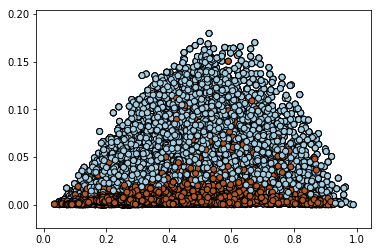

In [33]:
# Plot features using predictions to color datapoints
#Rødt er predicted til å være vei
plt.scatter(X[:, 0], X[:, 1], c=best_Z, edgecolors='k', cmap=plt.cm.Paired)

In [29]:
print(best_Z)

[0.21982084 0.20887677 0.14896801 ... 0.17992729 0.10071132 0.2991119 ]


In [34]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

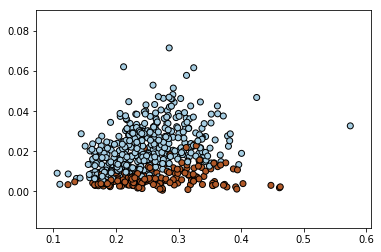

In [79]:
# Run prediction on the img_idx-th image
img_idx = 99
patch_size=16


Xi = [img_crop(imgs[i], patch_size, patch_size) for i in range(1)]
Xi = np.asarray([Xi[i][j] for i in range(1) for j in range(len(Xi[i]))]) 

correct_labeling_testimg = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(1)]
correct_labeling_testimg =  np.asarray([correct_labeling_testimg[i][j] for i in range(1)
                                        for j in range(len(correct_labeling_testimg[i]))])
correct_labeling_testimg = np.asarray([value_to_class(np.mean(correct_labeling_testimg[i])) for
                                       i in range(len(correct_labeling_testimg))])




Zi = model.predict(Xi)
for i in range (len(Zi)):
    if(Zi[i]<0.3):
        Zi[i] =0
    else:
        Zi[i]=1
Zi = np.reshape(Zi, (625,))


Xmap = np.asarray([ extract_features_2d(Xi[i]) for i in range(len(Xi))])
plt.scatter(Xmap[:, 0], Xmap[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

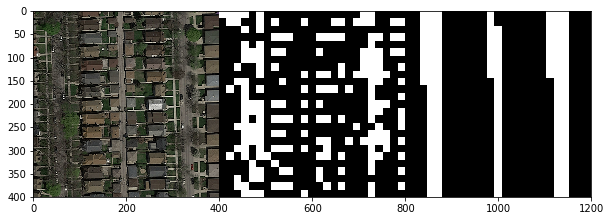

In [80]:
# Display prediction as an image

w = gt_imgs[0].shape[0]
h = gt_imgs[0].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
correct_im = label_to_img(w, h, patch_size, patch_size, correct_labeling_testimg)
cimg = concatenate_images(imgs[0], predicted_im)
cimg = concatenate_images(cimg, correct_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')




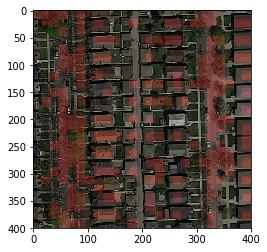

In [76]:
new_img = make_img_overlay(imgs[0], predicted_im)

plt.imshow(new_img)